## Импорты

In [76]:
# импортируем необходимые библиотеки, классы и функции
import os
from datetime import datetime
import winsound
from etna.core import load
from etna.analysis import plot_backtest, plot_forecast
import random
from functools import partial
from pathlib import Path
import numpy as np
import optuna
import pandas as pd
from etna.datasets import TSDataset
from etna.datasets import generate_ar_df
from etna.metrics import (MAE, MSE, SMAPE, Sign)
from etna.models import CatBoostPerSegmentModel
from etna.pipeline import Pipeline, AutoRegressivePipeline
from etna.transforms import (LagTransform, 
                             LogTransform,
                             MeanTransform,
                             LinearTrendTransform,
                             TrendTransform)
from etna.transforms import (SegmentEncoderTransform,
                             StandardScalerTransform, 
                             MinMaxScalerTransform,
                             RobustScalerTransform,
                             TimeSeriesImputerTransform)
from etna.transforms.decomposition import RupturesChangePointsModel
from etna.analysis import plot_feature_relevance
from etna.analysis import ModelRelevanceTable
from sklearn.ensemble import RandomForestRegressor
from ruptures.detection import Binseg
from etna.datasets import generate_ar_df
import warnings
warnings.filterwarnings('ignore')

## Пути к файлам модели и данных на диске и общие переменные

In [77]:
TRAIN_DATASET_PATH = "C:\\Users\\andre\\OneDrive\\Рабочий стол\\traindataset.csv"
MODEL_SAVING_PATH = "C:\\Users\\andre\\OneDrive\\Рабочий стол\\ВКР\\Модели\\catboost_etna.zip"
USING_MEASURE_POINTS = 166560
HORIZON = 72
VALIDATION_MEASURE_POINTS_END = 171400+72 # 175320

## Функция загрузки данных и преобразования в формат ETNA

In [78]:
def get_etna_dataframe(sw_path, using_measure_points, target_list, regressors_list, with_solar_cycle_order_day_feature):
  # Получаем очищенные данные
  df = pd.read_csv(sw_path)
  df = df.head(using_measure_points)
  # преобразовываем столбец timestamp в столбец с временными метками
  df['timestamp'] = pd.to_datetime(df['timestamp'])

  # создаем дополнительную фичу в виде порядкового дня солнечного цикла
  if with_solar_cycle_order_day_feature:
      df = create_solar_cycle_order_day_feature(df=df, solar_cycles=solar_cycles)
      regressors_list.append('solar_cycle_day')
  
  df_target = df[target_list]
  df_regressors = df[regressors_list]
  # Подготавливаем регрессоры
  if regressors_list:
    df_regressors.columns = ["timestamp"] + [f"regressor_{i}_{regressors_list[i + 1]}" for i in range(len(regressors_list) - 1)]
    df_regressors["segment"] = "segment_0"
    df_regressors = TSDataset.to_dataset(df_regressors)
  # подготавливаем dataframe с целевой переменной
  df_target['target'] = df_target['v_plasma']
  df_target.drop(columns=['v_plasma'], inplace=True)
  df_target['segment'] = 'segment_0'
  # превращаем датафрейм
  # с плоским индексом в датафрейм с мультииндексом
  df_target = TSDataset.to_dataset(df_target)
  # превращаем датафрейм в объект TSDataset
  if not regressors_list:
    ts_target = TSDataset(df_target, freq='h')
  else:
    ts_target = TSDataset(df_target, freq='h', df_exog=df_regressors)
  # выполняем импутацию пропусков
  imputer = TimeSeriesImputerTransform(in_column='target',
                                      strategy='running_mean')
  ts_target.fit_transform([imputer])

  if regressors_list:
    for i in range(len(regressors_list)-1):
      imputer = TimeSeriesImputerTransform(in_column=f"regressor_{i}",
                                      strategy='running_mean')
      ts_target.fit_transform([imputer])

  return ts_target

## Функция добавления порядкового дня солнечного цикла в качестве экзогенной переменной

#### Данные о началах солнечных циклов

In [79]:
solar_cycles = [
    {"cycle": 1, "start": "1755-02"},
    {"cycle": 2, "start": "1766-06"},
    {"cycle": 3, "start": "1775-06"},
    {"cycle": 4, "start": "1784-09"},
    {"cycle": 5, "start": "1798-04"},
    {"cycle": 6, "start": "1810-07"},
    {"cycle": 7, "start": "1823-05"},
    {"cycle": 8, "start": "1833-11"},
    {"cycle": 9, "start": "1843-07"},
    {"cycle": 10, "start": "1855-12"},
    {"cycle": 11, "start": "1867-03"},
    {"cycle": 12, "start": "1878-12"},
    {"cycle": 13, "start": "1890-03"},
    {"cycle": 14, "start": "1902-01"},
    {"cycle": 15, "start": "1913-07"},
    {"cycle": 16, "start": "1923-08"},
    {"cycle": 17, "start": "1933-09"},
    {"cycle": 18, "start": "1944-02"},
    {"cycle": 19, "start": "1954-04"},
    {"cycle": 20, "start": "1964-10"},
    {"cycle": 21, "start": "1976-03"},
    {"cycle": 22, "start": "1986-09"},
    {"cycle": 23, "start": "1996-08"},
    {"cycle": 24, "start": "2008-12"},
    {"cycle": 25, "start": "2019-12"}
]

#### Функция добавления порядкового дня солнечного цикла

In [80]:
def create_solar_cycle_order_day_feature(df: pd.DataFrame, solar_cycles):
    # Преобразование строковых дат в datetime
    for cycle in solar_cycles:
        cycle['start'] = datetime.strptime(cycle['start'], '%Y-%m')
    
    # Функция для определения солнечного цикла и порядкового номера дня
    def get_solar_cycle_day(timestamp):
        for i in range(len(solar_cycles)-1, -1, -1):
            if timestamp >= solar_cycles[i]['start']:
                cycle_day = (timestamp - solar_cycles[i]['start']).days + 1
                return cycle_day
        return None
    
    # Применение функции к DataFrame
    df['solar_cycle_day'] = df['timestamp'].apply(get_solar_cycle_day)
    return df

## Функция отображения статистик по TSData и Pipeline

In [81]:
def print_TSDataset_statistic(df: TSDataset):
    print(f"*** Статистика по набору данных: ***\n {df.describe()} ]\n\n")
    print("Минимальные значения:")
    print(df.df.min())
    print("\nМаксимальные значения:")
    print(df.df.max())

def print_pipeline_transform_and_regressors(pipeline, regressors):
    print("\nСписок преобразований пайплайна:\n")
    for transform in pipeline.transforms:
        print(transform)
    print(f"\n*** Переменные регрессоры: ***\n {regressors_list} \n \n")

def play_end_sound():
    winsound.PlaySound('SystemAsterisk', winsound.SND_FILENAME)
    winsound.PlaySound('SystemAsterisk', winsound.SND_FILENAME)
    winsound.PlaySound('SystemAsterisk', winsound.SND_FILENAME)

## Функция создания модели, трансформеров, пайплайна и обучения модели

In [89]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)


def learn_model(horizon, 
                catboost_param_iterations: int = 5,
                catboost_param_depth: int = 5,
                lags: int = 10,
                with_lags: bool = False,
                target_list: list = None, 
                regressors_list: list = None,
                with_median: bool = False,
                median_window_size: int = 80,
                ts: TSDataset = None,
                with_backtest = True,
                with_saving_model: bool = False,
               ):
    set_seed()
    transforms=[
             # MinMaxScalerTransform(in_column=None),
    ]
    if with_lags:
        transforms.append(LagTransform(in_column="target",
                                       lags=list(range(horizon, horizon + lags)), 
                                       out_column="lag_target"))
    if with_median:
        MeanTransform(in_column='target',
                      window=median_window_size, 
                      out_column='mean_target')

    # если список регрессоров не пуст, то добавляем лаги для них
    if regressors_list:
        if with_lags:
            for i in range(len(regressors_list)-1):
                # не добавляем лаги для номера дня в солнечном цикле
                if regressors_list[i + 1] != 'solar_cycle_day' and regressors_list[i + 1] != None:
                    lags_regressor = LagTransform(in_column=f"regressor_{i}_{regressors_list[i + 1]}",
                                                  lags=list(range(horizon, horizon+lags)),
                                                  out_column=f"lag_regressor_{i}_{regressors_list[i + 1]}")
                    transforms.append(lags_regressor)
        if with_median: 
            for i in range(len(regressors_list)-1):
                # не создаем медианы для номера дня в солнечном цикле
                if regressors_list[i + 1] != 'solar_cycle_day' and regressors_list[i + 1] != None:
                    median_regressor = MeanTransform(in_column=f"regressor_{i}_{regressors_list[i + 1]}",
                                                     window=median_window_size,
                                                     out_column=f"median_regressor_{i}_{regressors_list[i + 1]}")
                    transforms.append(median_regressor)

    # задаем модель и признаки
    pipeline = Pipeline(
        model = CatBoostPerSegmentModel(iterations=catboost_param_iterations,
                                        # The maximum number of trees that can be built when solving
                                        # machine learning problems.
                                        depth=catboost_param_depth,
                                        # Depth of the tree. The range of supported values depends
                                        # on the processing unit type and the type of the selected loss function
                                        #l2_leaf_reg=10.0 не нужно
                                        # learning_rate=0.001 не нужно
                                       ),
        transforms=transforms,
        horizon=horizon,
        # step=1, # Параметр для использования с AutoregressivePipeline, количество шагов прогнозирования за один раз
    )
    print("\n*** Запустился pipeline ***\n")
    if with_backtest:
        metrics, forecast_df, fold_info_df = pipeline.backtest(ts=ts, 
                                      metrics=[MAE(), SMAPE(), MSE()],
                                      n_jobs=5,
                                      n_folds=5,
                                      aggregate_metrics=True,
                                      )
    
    print_pipeline_transform_and_regressors(pipeline, regressors_list)
    print(f"Параметры модели CatBoost: {pipeline.model.to_dict}")
    if with_saving_model:
        pipeline.fit(ts)
        pipeline.save(MODEL_SAVING_PATH)
    return metrics, forecast_df, fold_info_df

## Запуск обучения

*** Статистика по набору данных: ***
           start_timestamp       end_timestamp  length  num_missing  \
segments                                                             
segment_0      2000-01-01 2018-12-31 23:00:00  166560            0   

           num_segments  num_exogs  num_regressors  num_known_future freq  
segments                                                                   
segment_0             1         11               0                 0    h   ]


Минимальные значения:
segment    feature               
segment_0  regressor_0_AL           -2452.00
           regressor_10_B_mag_avg       0.40
           regressor_1_AU               0.00
           regressor_2_AE               3.00
           regressor_3_Kp               0.00
           regressor_4_p_flow           0.03
           regressor_5_n_p              0.10
           regressor_6_n_plasma         1.00
           regressor_7_R                0.00
           regressor_8_f107_adj        64.60
           re

[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=5)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    5.5s



Список преобразований пайплайна:

LagTransform(in_column = 'target', lags = [72, 73, 74, 75, 76, 77, 78, 79, 80, 81], out_column = 'lag_target', )
LagTransform(in_column = 'regressor_0_AL', lags = [72, 73, 74, 75, 76, 77, 78, 79, 80, 81], out_column = 'lag_regressor_0_AL', )
LagTransform(in_column = 'regressor_1_AU', lags = [72, 73, 74, 75, 76, 77, 78, 79, 80, 81], out_column = 'lag_regressor_1_AU', )
LagTransform(in_column = 'regressor_2_AE', lags = [72, 73, 74, 75, 76, 77, 78, 79, 80, 81], out_column = 'lag_regressor_2_AE', )
LagTransform(in_column = 'regressor_3_Kp', lags = [72, 73, 74, 75, 76, 77, 78, 79, 80, 81], out_column = 'lag_regressor_3_Kp', )
LagTransform(in_column = 'regressor_4_p_flow', lags = [72, 73, 74, 75, 76, 77, 78, 79, 80, 81], out_column = 'lag_regressor_4_p_flow', )
LagTransform(in_column = 'regressor_5_n_p', lags = [72, 73, 74, 75, 76, 77, 78, 79, 80, 81], out_column = 'lag_regressor_5_n_p', )
LagTransform(in_column = 'regressor_6_n_plasma', lags = [72, 73, 74,

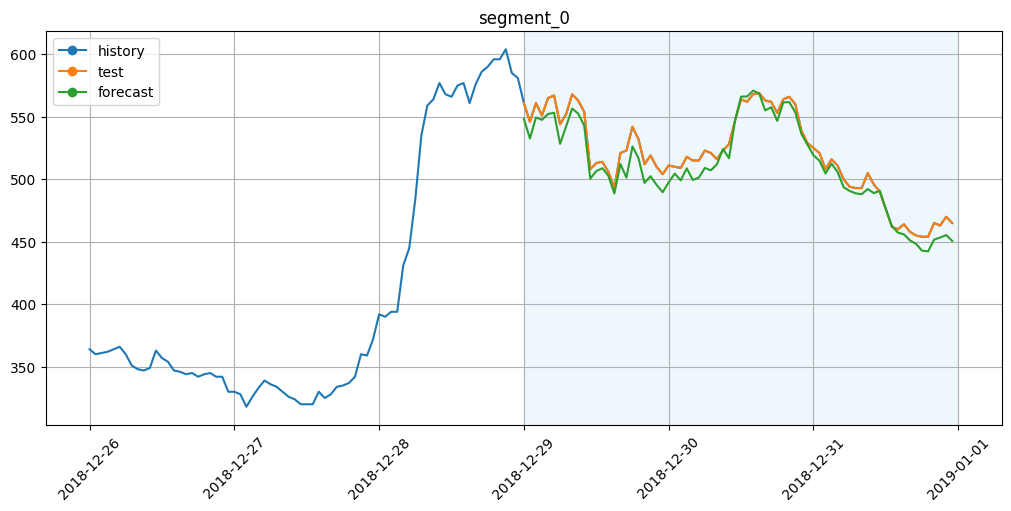

In [90]:
target_list = ['timestamp',
              'v_plasma']

regressors_list = [
                   'timestamp',
                   'AL',
                   'AU',
                   'AE',
                   'Kp',
                   'p_flow',
                   'n_p',
                   'n_plasma',
                   'R',
                   'f107_adj',
                   'Dst',
                   'B_mag_avg',
    
                   # 'T_p',
                   # 'E'
                   # 'B_mag',
                   # 'B_x',
                   # 'B_y_GSE',
                   # 'B_z_GSE',
                   # 'B_y_GSM',
                   # 'B_z_GSM',
]

ts = get_etna_dataframe(sw_path=TRAIN_DATASET_PATH,
                        using_measure_points=USING_MEASURE_POINTS,
                        target_list=target_list, 
                        regressors_list=regressors_list,
                        with_solar_cycle_order_day_feature=False)
print_TSDataset_statistic(ts)

metrics, forecast_df, fold_info = learn_model(horizon = HORIZON,
                                              catboost_param_iterations=200,
                                              catboost_param_depth=12,
                                              ts = ts,
                                              with_lags=True,
                                              lags = 10,
                                              with_median = True,
                                              median_window_size=40,
                                              # Для применения создания лагов 
                                              # только из выбранных переменных
                                              # regressors_list = ['timestamp',
                                              #                     None,
                                              #                     None,
                                              #                     None,
                                              #                     'Kp',
                                              #                     'p_flow',
                                              #                     'n_p',
                                              #                     None,
                                              #                     'R',
                                              #                     'f107_adj',
                                              #                     'Dst',
                                              #                     'B_mag_avg'],
                                              regressors_list=regressors_list,
                                              # Если True - обучает модель и отрисовывает график перекрестной проверки
                                              with_backtest=True,
                                              # Если True - обучает модель и сохраняет на диск
                                              with_saving_model=False)

plot_backtest(forecast_df, ts, history_len=72)
print("\n*** Метрики обучения по сегментам ***")
print(metrics)
play_end_sound()

## Получение предсказания

*** Статистика по датасету для прогнозирования ***

*** Статистика по набору данных: ***
           start_timestamp       end_timestamp  length  num_missing  \
segments                                                             
segment_0      2000-01-01 2019-07-21 15:00:00  171400            0   

           num_segments  num_exogs  num_regressors  num_known_future freq  
segments                                                                   
segment_0             1         11               0                 0    h   ]


Минимальные значения:
segment    feature               
segment_0  regressor_0_AL           -2452.00
           regressor_10_B_mag_avg       0.40
           regressor_1_AU               0.00
           regressor_2_AE               3.00
           regressor_3_Kp               0.00
           regressor_4_p_flow           0.03
           regressor_5_n_p              0.10
           regressor_6_n_plasma         1.00
           regressor_7_R                0.00
      

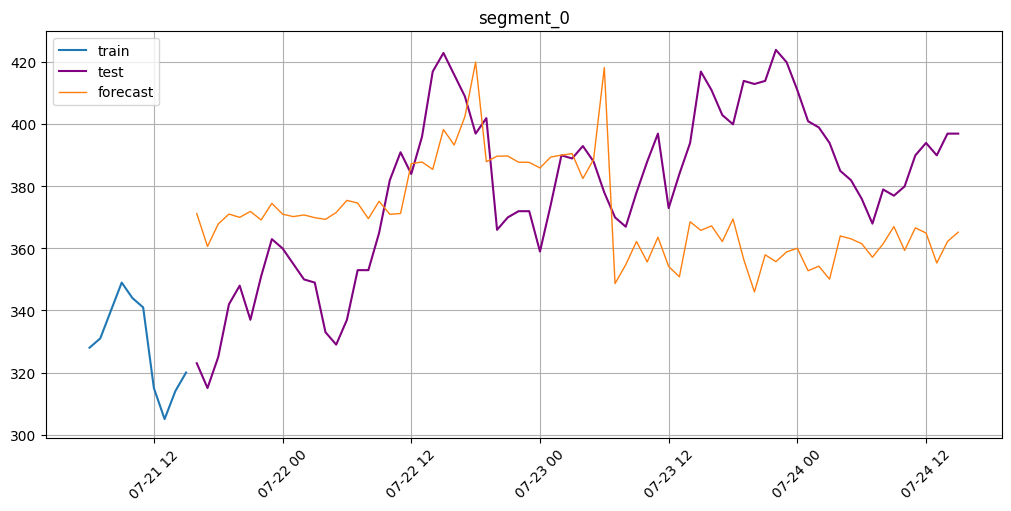

In [88]:
df_for_predict = get_etna_dataframe(sw_path=TRAIN_DATASET_PATH,
                                    using_measure_points=(VALIDATION_MEASURE_POINTS_END - HORIZON),
                                    target_list=target_list, 
                                    regressors_list=regressors_list,
                                    with_solar_cycle_order_day_feature=False)

df_real = get_etna_dataframe(sw_path=TRAIN_DATASET_PATH,
                             using_measure_points=VALIDATION_MEASURE_POINTS_END,
                             target_list=target_list, 
                             regressors_list=regressors_list,
                             with_solar_cycle_order_day_feature=False)
df_real = TSDataset(df_real.df.tail(horizon), freq='h')

print("*** Статистика по датасету для прогнозирования ***\n")
print_TSDataset_statistic(df_for_predict)
print("*** Статистика по датасету c настоящими значениями прогноза ***\n")
print_TSDataset_statistic(df_for_predict)



pipeline = load(MODEL_SAVING_PATH)
print_pipeline_transform_and_regressors(pipeline, regressors_list)

print("Получаем предсказание...")

forecast = pipeline.forecast(df_for_predict)

plot_forecast(forecast_ts=forecast, test_ts=df_real, train_ts=df_for_predict, n_train_samples=10)
print(f"""Последние три значения датафрейма для предсказания:\n{df_for_predict.tail(3)}\n\n 
Предсказание(первые 3):\n {forecast.df["segment_0"]["target"].head(3)}\n\n 
Реальные данные (первые 3):\n {df_real.df["segment_0"]["target"].head(3)}\n\n""")
play_end_sound()

## Функция отрисовки важности признаков

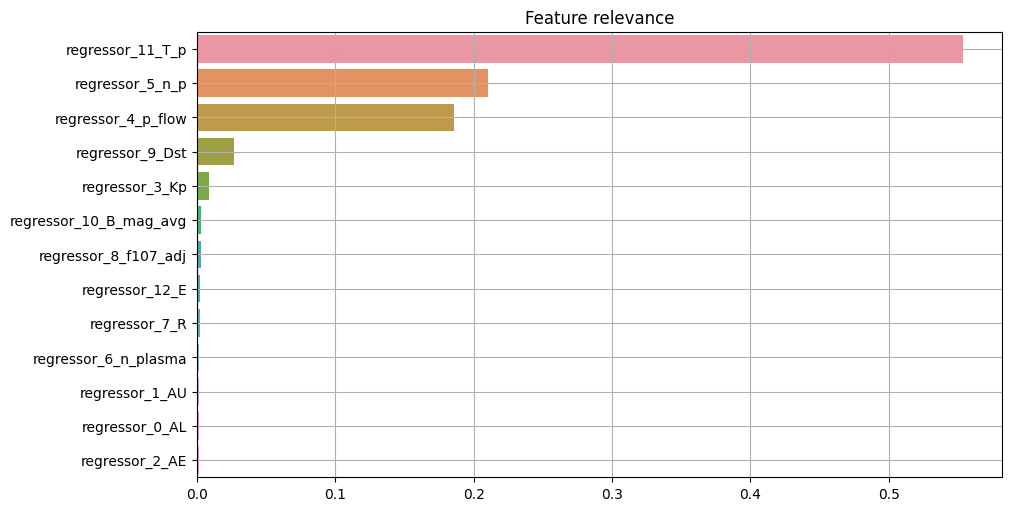

In [73]:
def plot_original_feature_revenue():
    regressors_list = [
                    'timestamp',
                   'AL', # какие-то проблемы
                   'AU', # нет пропусков
                   'AE', # нет пропусков
                   'Kp', # нет пропусков
                   'p_flow', # нет пропусков
                   'n_p', # нет пропусков
                   'n_plasma', # нет пропусков
                   'R', # нет пропусков
                   'f107_adj', # нет пропусков
                   'Dst', # нет пропусков
                   'B_mag_avg',
    
                   # 'T_p',
                   # 'E'
                   # 'B_mag',
                   # 'B_x',
                   # 'B_y_GSE',
                   # 'B_z_GSE',
                   # 'B_y_GSM',
                   # 'B_z_GSM',
    ]
    ts = get_etna_dataframe(sw_path=TRAIN_DATASET_PATH,
                            using_measure_points=USING_MEASURE_POINTS,
                            target_list=target_list, 
                            regressors_list=regressors_list,
                            with_solar_cycle_order_day_feature=False)
    
    plot_feature_relevance(ts=ts,
                           relevance_table=ModelRelevanceTable(),
                           normalized=True,
                           top_k=20,
                           relevance_params=dict(model=RandomForestRegressor(n_estimators=100)))

# Запуск функции
plot_original_feature_revenue()